# **I. Environment setup**

In [16]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import mne
from Dataset import Dataset

In [ ]:
import matplotlib
%matplotlib inline

# **II. Preprocessing**
## **1. Some information on the current dataset**
* **Task**: Classification for 6 mental states of passive, left and right-hand, left and right-leg, and tongue movements
* **Methods**:
    * 3 BCI interation segments, each with a 2-minute break, form one recording session.
    * Participants are given 2.5 minutes at the beginning to acclimatize to the recording session's conditions.
    * Afterwards, each interaction segment is administered for 15 minutes.
$\rightarrow$ **EEG data is continuously measured for a total length of 50 - 55 minutes.**
* **Data acquisitions**
    * **No electromagnetic shielding or artifact control** was attempted for the recordings.
    * Out of 22 channels used, the 2 ground leads are labeled $A_1$ and $A_2$. $X_3$ is used for data synchronization.
    * Hardware filters of $0.53 - 70 Hz$ and $0.53 - 100 Hz$ are applied for EEG data recorded at sampling rates of $200 Hz$ and $1000 Hz$ respectively.
    * A $50Hz$ notch filter is also applied to reduce electrical grid interference.
    * **No terminal motion and E&M-related interference** occurred during data collection.
    * **All electrode impedances were below specified levels** at the start and end of the recording session, and no other technical issues were present.
    * **Post-hoc modifications** of data of any kinds were **not applied** to present researchers with the raw-est data possible. 

## **2. Data extraction and formatting**

In [18]:
my_dataset = Dataset("data\\HaLTSubjectF1602026StLRHandLegTongue.mat")
my_dataset.extract_file()
my_dataset.format_data()
my_dataset.add_montage()

Creating RawArray with float64 data, n_channels=22, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


## **3. Removing bad channels (interpolation if needed)**
The most common way to detect "bad" channels is through visualization. We can either:
* Plot the raw data **(If the data is really large, considered not do this)**
* Plot the Power Spectrum Density (PSD) of each channel to detect for outliers

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


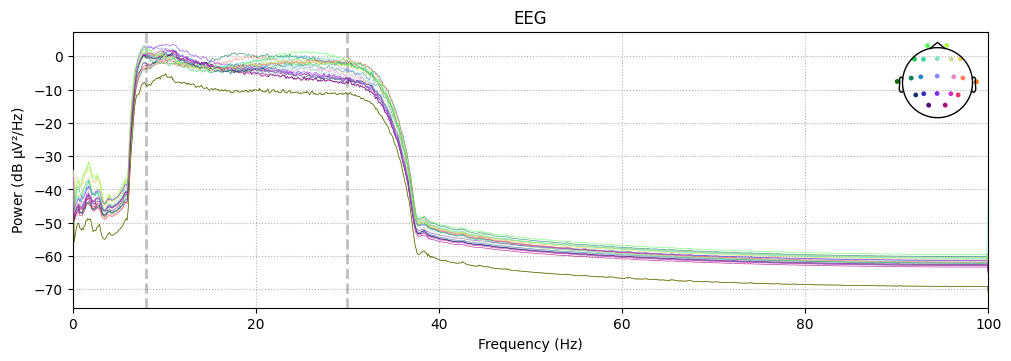

In [49]:
raw = my_dataset.data
raw.compute_psd().plot()
plt.show()
plt.close("all")

## **4. Filtering**
Let's not make things complicated for now, we are working in the domain of Motor Imagery. It is widely known that the frequency bands presenting important individual features are *Mu (8 - 12 Hz)* and *Beta (13 - 30 Hz)* band.

In [20]:
raw.filter(l_freq = 8, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 331 samples (1.655 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


<RawArray | 21 x 667000 (3335.0 s), ~106.9 MB, data loaded>

## **5. Re-referencing**

In [21]:
raw.set_eeg_reference(["A1", "A2"])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 21 x 667000 (3335.0 s), ~106.9 MB, data loaded>

## **6. Artifact detection**

In [22]:
tmin = -0.5
tmax = 1.5

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.
Added the following bipolar channels:
EOG
Using EOG channel: EOG
EOG channel index for this subject is: [21]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 441 significant peaks
Number of EOG events det

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
441 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 441 events and 401 original time points ...
0 bad epochs dropped


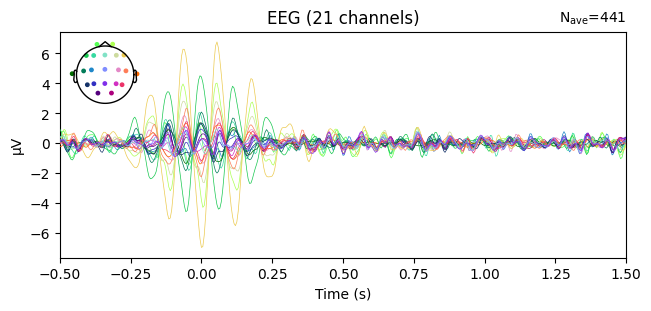

In [36]:
# EOG arfifacts (eye movements)
raw_eog = raw.copy()
eog_id = {"EOG artifacts" : 998}
raw_eog = mne.set_bipolar_reference(raw_eog, anode = "Fp1", cathode = "Fp2", ch_name = "EOG", drop_refs = False)
raw_eog.set_channel_types({"EOG" : "eog"})
eog_events = mne.preprocessing.find_eog_events(raw_eog, ch_name = "EOG")
eog_epochs = mne.Epochs(raw_eog, eog_events, event_id = eog_id, tmin = tmin, tmax = tmax, baseline = None, preload = True)
eog_epochs.average().plot()
plt.show()
plt.close("all")

Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 5180 (average pulse 93.19340329835082 / min.)
Not setting metadata
5180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5180 events and 401 original time points ...
0 bad epochs dropped


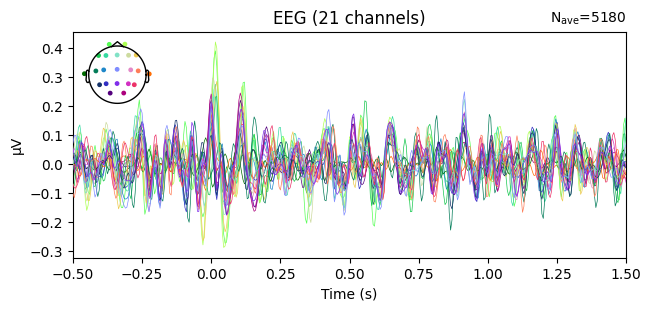

In [40]:
# ECG artifacts (heartbeats)
ecg_id = {"ECG artifacts" : 999}
raw_ecg = raw.copy()
channels_for_ecg = ["C3", "C4", "Cz"]
ecg_signal = raw_ecg.get_data(picks = channels_for_ecg).mean(axis = 0)
ecg_data = np.reshape(ecg_signal, (1, -1))
ecg_info = mne.create_info(ch_names = ["ECG"], sfreq = raw_ecg.info["sfreq"], ch_types = ["ecg"])
ecg_channel = mne.io.RawArray(ecg_data, ecg_info)
raw_ecg.add_channels([ecg_channel], force_update_info=True)
ecg_events, _, _ = mne.preprocessing.find_ecg_events(raw_ecg, ch_name = "ECG")
ecg_epochs = mne.Epochs(raw_ecg, ecg_events, event_id = ecg_id, tmin = tmin, tmax = tmax, baseline = None, preload = True)
ecg_epochs.average().plot()
plt.show()
plt.close("all")

## **7. Artifact correction using ICA**
CA works best on continuous data. So you shouldn't divide your data into epochs before this process.

In [41]:
# Setting an EOG channel based on EEC channels
raw_eog_ecg = raw.copy()
raw_eog_ecg = mne.set_bipolar_reference(raw_eog_ecg, anode = "Fp1", cathode = "Fp2", ch_name = "EOG", drop_refs = False)
raw_eog_ecg.set_channel_types({"EOG" : "eog"})

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.
Added the following bipolar channels:
EOG


<RawArray | 22 x 667000 (3335.0 s), ~112.0 MB, data loaded>

In [42]:
# Setting an ECG channel from EEG channels
channels_for_ecg = ["C3", "C4", "Cz"]
ecg_signal = raw_eog_ecg.get_data(picks = channels_for_ecg).mean(axis = 0)
ecg_data = np.reshape(ecg_signal, (1, -1))
ecg_info = mne.create_info(ch_names = ["ECG"], sfreq = raw_eog_ecg.info["sfreq"], ch_types = ["ecg"])
ecg_channel = mne.io.RawArray(ecg_data, ecg_info)
raw_eog_ecg.add_channels([ecg_channel], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


<RawArray | 23 x 667000 (3335.0 s), ~117.1 MB, data loaded>

In [43]:
ica = mne.preprocessing.ICA(random_state=42, method='fastica')
ica.fit(raw_eog_ecg)

Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Fitting ICA took 21.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,47 iterations on raw data (667000 samples)
ICA components,20
Available PCA components,21
Channel types,eeg
ICA components marked for exclusion,—


In [44]:
# Automatically find EOG and ECG components
eog_indices, eog_scores = ica.find_bads_eog(raw_eog_ecg)
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_eog_ecg)

Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using threshold: 0.36 for CTPS ECG detection
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 5235 (average pulse 94.18290854572713 / min.)
Not setting metadata
5235 matching events found
No baseline correction applied
Using data from preloaded Raw for 5235 events and 201 original time points ...
0 bad epochs dropped


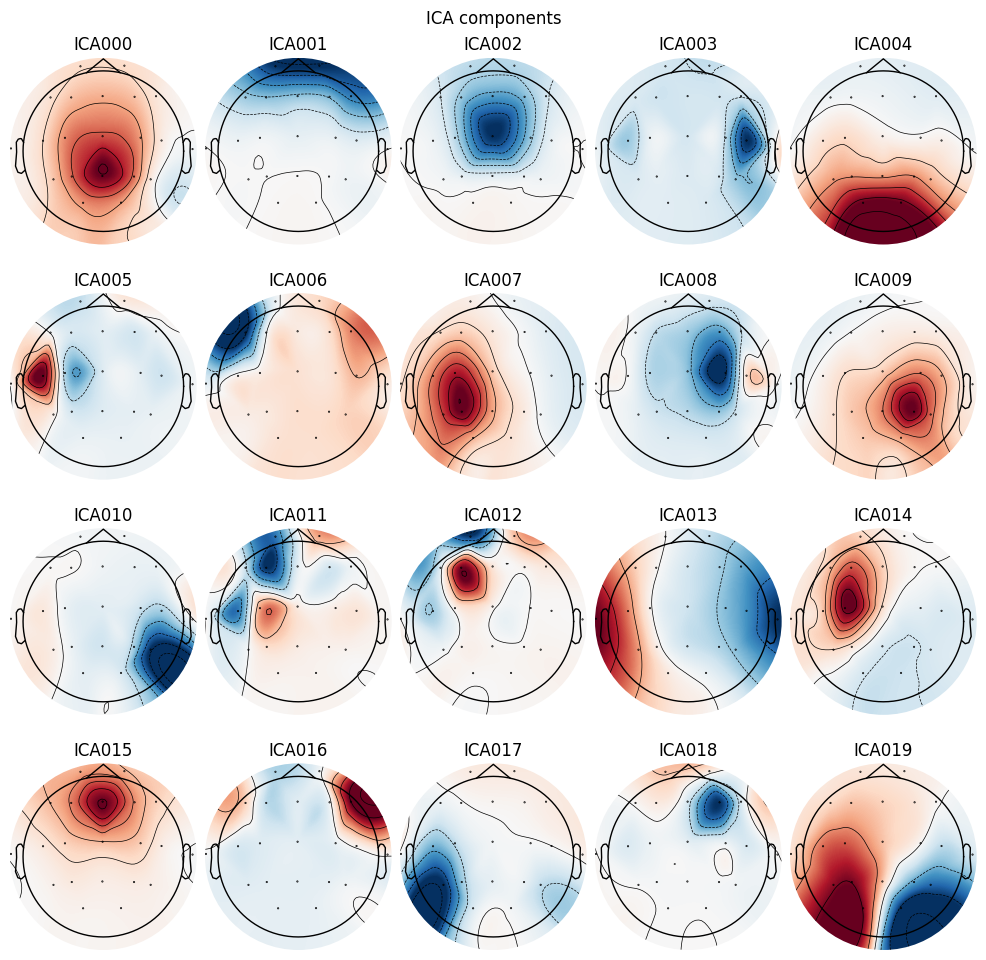

In [45]:
ica.plot_components()
plt.show()
plt.close("all")

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 21 PCA components


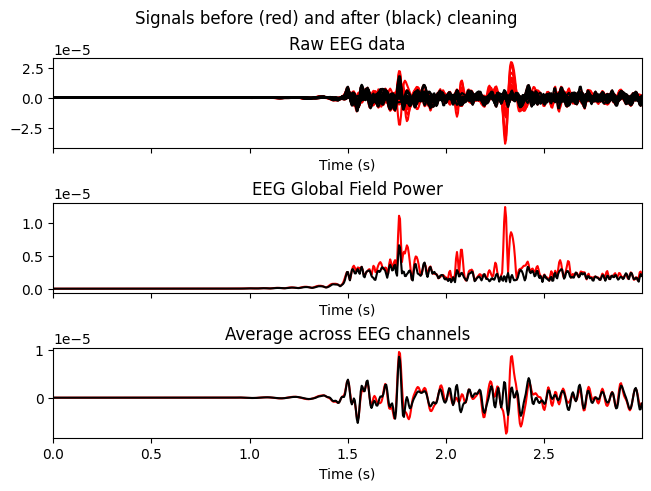

In [46]:
# Removing the 1, 6, and 13 ICA components
ica.plot_overlay(raw_eog_ecg, exclude = [1, 6, 13])
plt.show()
plt.close("all")

In [47]:
ica.exclude = [1, 6, 13]
raw_cleaned = ica.apply(raw_eog_ecg.copy())

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 21 PCA components


### **Question: Why do <code>mne.preprocessing.find_ecg_events</code> and <code>mne.preprocessing.find_eog_events</code> return many artifacts but <code>ica.find_bads_eog</code> and <code>ica.find_bads_ecg</code> indicate that there are no bad epochs?**

## **8. Saving the cleaned data**

In [48]:
raw_cleaned.save("..\\cleaned_data.fif", overwrite=True)

Writing c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23440\4169349060.py:1: RuntimeWarning: This filename (c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned.save("..\\cleaned_data.fif", overwrite=True)


Closing c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif
[done]
